### Perform explanation based on randomly flagging one or more branches.
For n_branches_active_i in n_branches:
   &nbsp; - For trial_i in n_trials:
   &emsp;    - Randomly select n_branches_active_i and flag them
   &emsp;    - Compute precision, recall and other performance metrics
   &nbsp; - Compute mean of performance metrics across trials

In [1]:
# import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from pathlib import Path

# local
from utils_postprocessing import top_n, threshold

In [2]:
rand_analysis_root_dir = Path('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/explainability/random_analysis/run_random_analysis_05-09-2023_1212')
rand_analysis_root_dir.mkdir(exist_ok=True)

get_max = True  # get max top-n
branch_idxs_to_keep = [1, 2, 3, 4, 6, 7]  # do not keep global flux and stellar
robo_cols = ['Global Flux Flag', 'Local Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'Stellar Flag', 'DV Flag', 'No Flag']
n_trials = 10

In [3]:
# Read Robovetter Minor Flags
robo_flags = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/interns/kaylie_explainability/kdd/robovetter_flags_all_DR25.csv')
robo_flags.head()

# adding no flag column for TCEs with no FP flags set to one
robo_flags['No Flag'] = 0
# robo_flags.loc[(robo_flags[robo_cols[:-1]] == 0).all(axis=1), 'No Flag'] = 1

tce_tbl = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/data/ephemeris_tables/kepler/q1-q17_dr25/11-17-2021_1243/q1_q17_dr25_tce_3-6-2023_1734.csv')
robo_flags['uid'] = robo_flags[['target_id', 'tce_plnt_num']].apply(lambda x: f'{x[0]}-{x[1]}', axis=1)
robo_flags['uid'].value_counts()
robo_flags = robo_flags.merge(tce_tbl[['uid', 'label']], on=['uid'], how='left', validate='one_to_one')
robo_flags.loc[robo_flags['label'] == 'PC', 'No Flag'] = 1

# choose only test set examples
test_set_examples = np.load('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/explainability/tfrecord_to_dict_data/run_04-26-2023_1249/all_test_data.npy', allow_pickle=True).item()
test_set_examples_uids = [f'{example[0]}-{example[1]}' for  example in zip(test_set_examples['example_info']['target_id'], test_set_examples['example_info']['tce_plnt_num'])]
robo_flags['uid'] = robo_flags[['target_id', 'tce_plnt_num']].apply(lambda x: '{}-{}'.format(x['target_id'], x['tce_plnt_num']), axis=1)
robo_flags = robo_flags.loc[robo_flags['uid'].isin(test_set_examples_uids)]

# # exclude non-KOIs
# tce_tbl = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/data/ephemeris_tables/kepler/q1-q17_dr25/11-17-2021_1243/q1_q17_dr25_tce_3-6-2023_1734.csv')
# robo_flags = pd.merge(robo_flags, tce_tbl[['target_id', 'tce_plnt_num', 'kepoi_name']], on=['target_id', 'tce_plnt_num'], validate='one_to_one', how='left')
# robo_flags = robo_flags.loc[~robo_flags['kepoi_name'].isna()]

In [4]:
robo_flags = np.array(robo_flags[robo_cols])
branch_flags = np.moveaxis(robo_flags, 0, -1)[branch_idxs_to_keep]
robo = np.moveaxis(branch_flags, 0, -1)
robo = np.array(robo[:, :-1])
robo_noflag = np.array(robo[:, -1])

In [5]:
# # Generate random scores
# branch_explanations_trials = np.nan * np.ones((n_trials, robo.shape[0], robo.shape[1]), dtype='float')
# for trial_i in range(n_trials):
#     # branch_explanations_trials[trial_i] = (np.random.random(robo.shape) - 0.5) * 2
#     branch_explanations_trials[trial_i] = np.random.random(robo.shape)
#
#     # # set no fp flags to one when all other flags have non-positive explanation scores
#     # idxs_allfpflags_nonpos = (branch_explanations_trials[trial_i][:, :-1] <= 0).all(axis=1)
#     # branch_explanations_trials[trial_i][:, -1] = 0
#     # branch_explanations_trials[trial_i][idxs_allfpflags_nonpos, -1] = 1
#
# np.save(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy', branch_explanations_trials)

# Compute top-n metrics for FP flags

In [6]:
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')
top_n_arr = np.arange(1,6)  # top-n values
# metrics to be computed for each top-n
metrics_dict = {
    'precision_micro': {'average': 'micro', 'zero_division': 1},
    'precision_macro': {'average': 'macro', 'zero_division': 1},
    'precision_weighted': {'average': 'weighted', 'zero_division': 1},

    'recall_micro': {'average': 'micro', 'zero_division': 1},
    'recall_macro': {'average': 'macro', 'zero_division': 1},
    'recall_weighted': {'average': 'weighted', 'zero_division': 1},

    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},

    'jaccard_micro': {'average': 'micro', 'zero_division': 1},
    'jaccard_macro': {'average': 'macro', 'zero_division': 1},
    'jaccard_weighted': {'average': 'weighted', 'zero_division': 1},
}
metrics_res = {'top_n': top_n_arr}
metrics_res.update({f'{metric_i}': np.zeros((len(top_n_arr), n_trials), dtype='float') for metric_i in metrics_dict})
metrics_res.update({f'{metric_i}': np.zeros((len(top_n_arr), n_trials), dtype='float') for metric_i in metrics_dict})
for trial_i in range(n_trials):

    for n_i, n in enumerate(top_n_arr):

        branch_explanations_topn = top_n(branch_explanations_trials[trial_i], n, get_max)

        for metric_i, metrics_params in metrics_dict.items():

            if 'precision' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = precision_score(robo, branch_explanations_topn, **metrics_params)
            elif 'recall' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = recall_score(robo, branch_explanations_topn, **metrics_params)
            elif 'hamming' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = 1 - hamming_loss(robo, branch_explanations_topn, **metrics_params)
            elif 'jaccard' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = jaccard_score(robo, branch_explanations_topn, **metrics_params)
            elif 'exact_match_ratio' in metric_i:
                metrics_res[metric_i][n_i][trial_i] = accuracy_score(robo, branch_explanations_topn, **metrics_params)

np.save(rand_analysis_root_dir / f'metrics_top_n_{top_n_arr[0]}-{top_n_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'top_n': top_n_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_dict})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_dict})
for metric_i, metrics_params in metrics_dict.items():
    for n_i, n in enumerate(top_n_arr):
        agg_metrics_res[f'{metric_i}_mean'][n_i] = np.mean(metrics_res[metric_i][n_i, :])
        agg_metrics_res[f'{metric_i}_std'][n_i] = np.std(metrics_res[metric_i][n_i, :], ddof=1)

agg_metrics_res_df = pd.DataFrame(agg_metrics_res)
agg_metrics_res_df.head()
agg_metrics_res_df.to_csv(rand_analysis_root_dir / f'metrics_top_n_{top_n_arr[0]}-{top_n_arr[-1]}.csv', index=False)

# Compute metrics across FP flags for a set of threshold values

In [7]:
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')

thr_arr = np.linspace(-1, 1, 21, endpoint=True)

# metrics to be computed for the given threshold
metrics_dict = {
    'precision_micro': {'average': 'micro', 'zero_division': 1},
    'precision_macro': {'average': 'macro', 'zero_division': 1},
    'precision_weighted': {'average': 'weighted', 'zero_division': 1},
    'precision_samples': {'average': 'samples', 'zero_division': 1},

    'recall_micro': {'average': 'micro', 'zero_division': 1},
    'recall_macro': {'average': 'macro', 'zero_division': 1},
    'recall_weighted': {'average': 'weighted', 'zero_division': 1},
    'recall_samples': {'average': 'samples', 'zero_division': 1},

    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},

    'jaccard_micro': {'average': 'micro', 'zero_division': 1},
    'jaccard_macro': {'average': 'macro', 'zero_division': 1},
    'jaccard_weighted': {'average': 'weighted', 'zero_division': 1},
    'jaccard_samples': {'average': 'samples', 'zero_division': 1},
}

metrics_res = {'thr': thr_arr}
metrics_res.update({metric_i: np.nan * np.ones((len(thr_arr), n_trials)) for metric_i in metrics_dict})

for trial_i in range(n_trials):
    for thr_i, thr in enumerate(thr_arr):

        branch_explanations_thr = threshold(branch_explanations_trials[trial_i], thr)
        # # add no_flag column; set to one when all other flags have non-positive explanation scores
        # branch_explanations_thr[(branch_explanations_thr[:, :-1] == 0).all(axis=1), -1] = 1

        for metric_i, metrics_params in metrics_dict.items():

            if 'precision' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = precision_score(robo, branch_explanations_thr, **metrics_params)
            elif 'recall' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = recall_score(robo, branch_explanations_thr, **metrics_params)
            elif 'hamming' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = 1 - hamming_loss(robo, branch_explanations_thr, **metrics_params)
            elif 'jaccard' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = jaccard_score(robo, branch_explanations_thr, **metrics_params)
            elif 'exact_match_ratio' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = accuracy_score(robo, branch_explanations_thr, **metrics_params)

np.save(rand_analysis_root_dir / f'metrics_thr_{thr_arr[0]}-{thr_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'thr': thr_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
for metric_i, metrics_params in metrics_dict.items():
    for thr_i, thr in enumerate(thr_arr):
        agg_metrics_res[f'{metric_i}_mean'][thr_i] = np.mean(metrics_res[metric_i][thr_i, :])
        agg_metrics_res[f'{metric_i}_std'][thr_i] = np.std(metrics_res[metric_i][thr_i, :], ddof=1)

metrics_res_df = pd.DataFrame(agg_metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(rand_analysis_root_dir / f'metrics_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

# Compute metrics for PC for a set of threshold values

In [8]:
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')

thr_arr = np.linspace(-1, 1, 21, endpoint=True)

# metrics to be computed for the given threshold
metrics_dict = {
    'precision': {'zero_division': 1},
    'recall': {'zero_division': 1},
    'hamming': {'sample_weight': None},
    'exact_match_ratio': {'sample_weight': None},
    'jaccard': {'zero_division': 1},
}

metrics_res = {'thr': thr_arr}
metrics_res.update({metric_i: np.nan * np.ones((len(thr_arr), n_trials)) for metric_i in metrics_dict})

for trial_i in range(n_trials):
    for thr_i, thr in enumerate(thr_arr):

        # add no_flag column; set to one when all other flags have non-positive explanation scores
        idxs_allfps_inactive = (branch_explanations_trials[trial_i] <= thr).all(axis=1)
        noflag_explanation = np.zeros((len(branch_explanations_trials[trial_i]), 1), dtype='float')
        noflag_explanation[idxs_allfps_inactive] = 1

        branch_explanations_thr = threshold(noflag_explanation, thr)

        for metric_i, metrics_params in metrics_dict.items():

            if 'precision' in metric_i:
                metrics_res[metric_i][thr_i][trial_i] = precision_score(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'recall' in metric_i:
                metrics_res[metric_i][thr_i][trial_i]  = recall_score(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'hamming' in metric_i:
                metrics_res[metric_i][thr_i][trial_i]  = 1 - hamming_loss(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'jaccard' in metric_i:
                metrics_res[metric_i][thr_i][trial_i]  = jaccard_score(robo_noflag, branch_explanations_thr, **metrics_params)
            elif 'exact_match_ratio' in metric_i:
                metrics_res[metric_i][thr_i][trial_i]  = accuracy_score(robo_noflag, branch_explanations_thr, **metrics_params)

np.save(rand_analysis_root_dir / f'metrics_pc_thr_{thr_arr[0]}-{thr_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'thr': thr_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(thr_arr), dtype='float') for metric_i in metrics_dict})
for metric_i, metrics_params in metrics_dict.items():
    for thr_i, thr in enumerate(thr_arr):
        agg_metrics_res[f'{metric_i}_mean'][thr_i] = np.mean(metrics_res[metric_i][thr_i, :])
        agg_metrics_res[f'{metric_i}_std'][thr_i] = np.std(metrics_res[metric_i][thr_i, :], ddof=1)

metrics_res_df = pd.DataFrame(agg_metrics_res)
metrics_res_df.head()
metrics_res_df.to_csv(rand_analysis_root_dir / f'metrics_pc_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

### Compute top-n precision and recall values for each feature group

In [9]:
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')
top_n_arr = np.arange(1, 6)  # top-n values
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']
# metrics to be computed for each top-n
metrics_res = {'top_n': top_n_arr}
for flag in flags:
    metrics_res[f'precision_{flag}'] = np.zeros((len(top_n_arr), n_trials))
    metrics_res[f'recall_{flag}'] = np.zeros((len(top_n_arr), n_trials))

for trial_i in range(n_trials):

    for n_i, n in enumerate(top_n_arr):

        branch_explanations_topn = top_n(branch_explanations_trials[trial_i], n, get_max)

        for flag_i in range(len(flags)):
            metrics_res[f'precision_{flags[flag_i]}'][n_i][trial_i] = precision_score(robo[:, flag_i], branch_explanations_topn[:, flag_i], zero_division=1)
            metrics_res[f'recall_{flags[flag_i]}'][n_i][trial_i] = recall_score(robo[:, flag_i], branch_explanations_topn[:, flag_i], zero_division=1)

np.save(rand_analysis_root_dir / f'precision_recall_per_flag_top_n_{top_n_arr[0]}-{top_n_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'top_n': top_n_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_res if 'top_n' not in metric_i})
agg_metrics_res.update({f'{metric_i}_std': np.zeros(len(top_n_arr), dtype='float') for metric_i in metrics_res if 'top_n' not in metric_i})
for metric_i in metrics_res:
    if 'top_n' in metric_i:
        continue
    for n_i, n in enumerate(top_n_arr):
        agg_metrics_res[f'{metric_i}_mean'][n_i] = np.mean(metrics_res[metric_i][n_i, :])
        agg_metrics_res[f'{metric_i}_std'][n_i] = np.std(metrics_res[metric_i][n_i, :], ddof=1)

agg_metrics_res_df = pd.DataFrame(agg_metrics_res)
agg_metrics_res_df.head()
agg_metrics_res_df.to_csv(rand_analysis_root_dir / f'precision_recall_per_flag_top_n_{top_n_arr[0]}-{top_n_arr[-1]}.csv', index=False)

In [13]:
# precision and recall for a set of threshold for each feature group

branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')

flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']
thr_arr = np.linspace(-1, 1, 21, endpoint=True)
# metrics to be computed for each threshold value
metrics_res = {'thr': thr_arr}
for flag in flags:
    metrics_res[f'precision_{flag}'] = np.zeros((len(thr_arr), n_trials))
    metrics_res[f'recall_{flag}'] = np.zeros((len(thr_arr), n_trials))

for trial_i in range(n_trials):

    for thr_i, thr in enumerate(thr_arr):

        branch_explanations_thr = threshold(branch_explanations_trials[trial_i], thr)

        for flag_i in range(len(flags)):
            metrics_res[f'precision_{flags[flag_i]}'][thr_i, trial_i] = precision_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)
            metrics_res[f'recall_{flags[flag_i]}'][thr_i, trial_i] = recall_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)

np.save(rand_analysis_root_dir / f'precision_recall_per_flag_thr_{thr_arr[0]}-{thr_arr[-1]}_trials.npy', metrics_res)

agg_metrics_res = {'thr': thr_arr}
agg_metrics_res.update({f'{metric_i}_mean': np.nan * np.ones(len(thr_arr), dtype='float') for metric_i in metrics_res if 'thr' not in metric_i})
agg_metrics_res.update({f'{metric_i}_std': np.nan * np.ones(len(thr_arr), dtype='float') for metric_i in metrics_res if 'thr' not in metric_i})
for metric_i in metrics_res:
    if 'thr' in metric_i:
        continue
    for thr_i, thr in enumerate(thr_arr):
        agg_metrics_res[f'{metric_i}_mean'][thr_i] = np.mean(metrics_res[metric_i][thr_i, :])
        agg_metrics_res[f'{metric_i}_std'][thr_i] = np.std(metrics_res[metric_i][thr_i, :], ddof=1)

agg_metrics_res_df = pd.DataFrame(agg_metrics_res)
agg_metrics_res_df.head()
agg_metrics_res_df.to_csv(rand_analysis_root_dir / f'precision_recall_per_flag_thr_{thr_arr[0]}-{thr_arr[-1]}.csv', index=False)

# Compute precision and recall for a threshold range

In [14]:
# rand_analysis_root_dir = Path('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/explainability/random_analysis/run_random_analysis_05-04-2023_1755')
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')

thr_arr = np.linspace(-1, 1, 100, endpoint=True)
avg_types = [
    'micro',
    'macro',
    'weighted',
    'samples',
]
for avg_type in avg_types:
    precision_arr, recall_arr = np.nan * np.zeros((len(thr_arr), n_trials), dtype='float'), np.nan * np.zeros((len(thr_arr), n_trials), dtype='float')

    for trial_i in range(n_trials):
        for thr_i, thr in enumerate(thr_arr):

            branch_explanations_thr = threshold(branch_explanations_trials[trial_i], thr)

            # branch_explanations_thr[:, -1] = 0
            # idxs_allfpflags_nonpos = (branch_explanations_thr[:, :-1] == 0).all(axis=1)
            # branch_explanations_thr[idxs_allfpflags_nonpos, -1] = 1

            precision_arr[thr_i, trial_i] = precision_score(robo, branch_explanations_thr, average=avg_type, zero_division=1)
            recall_arr[thr_i, trial_i] = recall_score(robo, branch_explanations_thr, average=avg_type, zero_division=1)

    np.save(rand_analysis_root_dir / f'precision_trials_{n_trials}_{avg_type}_avg_arr.npy', precision_arr)
    np.save(rand_analysis_root_dir / f'recall_trials_{n_trials}_{avg_type}_avg_arr.npy', recall_arr)

    precision_arr_avg = np.mean(precision_arr, axis=1)
    recall_arr_avg = np.mean(recall_arr, axis=1)
    np.save(rand_analysis_root_dir / f'precision_{avg_type}_avg_arr.npy', precision_arr_avg)
    np.save(rand_analysis_root_dir / f'recall_{avg_type}_avg_arr.npy', recall_arr_avg)

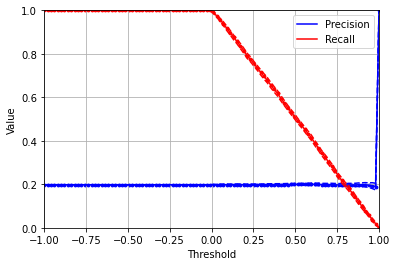

In [15]:
avg_type = 'macro'

precision_arr = np.load(rand_analysis_root_dir / f'precision_trials_{n_trials}_{avg_type}_avg_arr.npy')
recall_arr = np.load(rand_analysis_root_dir / f'recall_trials_{n_trials}_{avg_type}_avg_arr.npy')

precision_arr_avg = np.mean(precision_arr, axis=1)
precision_arr_se = np.sqrt(np.std(precision_arr, axis=1, ddof=1)) / precision_arr.shape[1]
recall_arr_avg = np.mean(recall_arr, axis=1)
recall_arr_se = np.sqrt(np.std(recall_arr, axis=1, ddof=1)) / recall_arr.shape[1]

f, ax = plt.subplots()
ax.scatter(thr_arr, precision_arr_avg, color='b', s=8)
ax.plot(thr_arr, precision_arr_avg, 'b', label='Precision')
ax.plot(thr_arr, precision_arr_avg + precision_arr_se, 'b--')
ax.plot(thr_arr, precision_arr_avg - precision_arr_se, 'b--')

ax.scatter(thr_arr, recall_arr_avg, color='r', s=8)
ax.plot(thr_arr, recall_arr_avg, 'r', label='Recall')
ax.plot(thr_arr, recall_arr_avg + recall_arr_se, 'r--')
ax.plot(thr_arr, recall_arr_avg - recall_arr_se, 'r--')

ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.grid()
ax.legend()
ax.set_xlim(thr_arr[[0, -1]])
ax.set_ylim([0, 1])
# ax.set_xscale('log')
f.savefig(rand_analysis_root_dir / f'precision_recall_{avg_type}_avg.pdf')

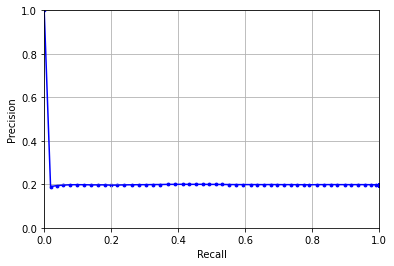

In [16]:
# plot PR curve
f, ax = plt.subplots()
ax.scatter(recall_arr_avg, precision_arr_avg, color='b', s=8)
ax.plot(recall_arr_avg, precision_arr_avg, 'b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(right=1)
f.savefig(rand_analysis_root_dir / f'pr_curve_{avg_type}_avg.pdf')

# Compute and plot precision and recall for no flags

In [17]:
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')

thr_arr = np.linspace(-1, 1, 100, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros((len(thr_arr), n_trials), dtype='float'), np.nan * np.zeros((len(thr_arr), n_trials), dtype='float')
for trial_i in range(n_trials):
    for thr_i, thr in enumerate(thr_arr):

        # add no_flag column; set to one when all other flags have non-positive explanation scores
        idxs_allfps_inactive = (branch_explanations_trials[trial_i] <= thr).all(axis=1)
        noflag_explanation = np.zeros((len(branch_explanations_trials[trial_i]), 1), dtype='float')
        noflag_explanation[idxs_allfps_inactive] = 1

        precision_arr[thr_i][trial_i] = precision_score(robo_noflag, noflag_explanation, zero_division=1)
        recall_arr[thr_i][trial_i] = recall_score(robo_noflag, noflag_explanation, zero_division=1)

precision_arr_avg = np.mean(precision_arr, axis=1)
recall_arr_avg = np.mean(recall_arr, axis=1)
np.save(rand_analysis_root_dir / 'precision_arr_noflag.npy', precision_arr_avg)
np.save(rand_analysis_root_dir / 'recall_arr_noflag.npy', recall_arr_avg)

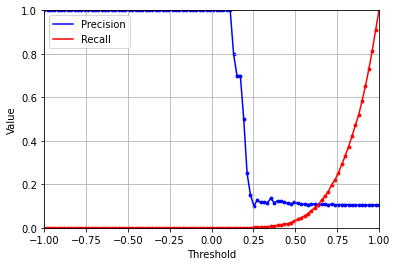

In [18]:
f, ax = plt.subplots()
ax.scatter(thr_arr, precision_arr_avg, color='b', s=8)
ax.plot(thr_arr, precision_arr_avg, 'b', label='Precision')
ax.scatter(thr_arr, recall_arr_avg, color='r', s=8)
ax.plot(thr_arr, recall_arr_avg, 'r', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.grid()
ax.legend()
ax.set_xlim(thr_arr[[0, -1]])
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# ax.set_xscale('log')
# ax.set_yscale('log')
f.savefig(rand_analysis_root_dir / f'precision_recall_thr_noneflag.pdf')

In [19]:
# compute precision and recall for no flag for a set of thresholds and save it to a csv file

branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')

thr_arr = np.linspace(-1, 1, 21, endpoint=True)
precision_arr, recall_arr = np.nan * np.zeros((len(thr_arr), n_trials), dtype='float'), np.nan * np.zeros((len(thr_arr), n_trials), dtype='float')
for trial_i in range(n_trials):
    for thr_i, thr in enumerate(thr_arr):

        # add no_flag column; set to one when all other flags have non-positive explanation scores
        idxs_allfps_inactive = (branch_explanations_trials[trial_i] <= thr).all(axis=1)
        noflag_explanation = np.zeros((len(branch_explanations_trials[trial_i]), 1), dtype='float')
        noflag_explanation[idxs_allfps_inactive] = 1

        precision_arr[thr_i, trial_i] = precision_score(robo_noflag, noflag_explanation, zero_division=1)
        recall_arr[thr_i, trial_i] = recall_score(robo_noflag, noflag_explanation, zero_division=1)

data_df = pd.DataFrame({'thr': thr_arr, 'precision_mean': np.mean(precision_arr, axis=1), 'precision_std': np.std(precision_arr, axis=1, ddof=1), 'recall': np.mean(recall_arr, axis=1), 'recall_std': np.std(recall_arr, axis=1, ddof=1)})
data_df.to_csv(rand_analysis_root_dir / 'precision_recall_noflag.csv', index=False)

# Plot histogram of scores for each flag

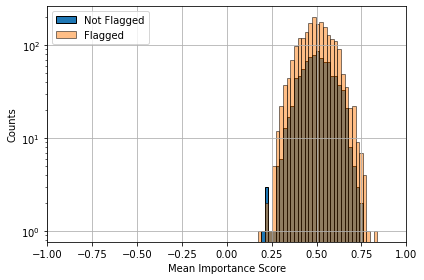

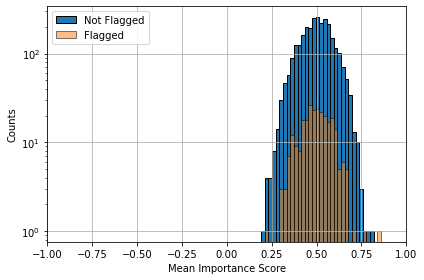

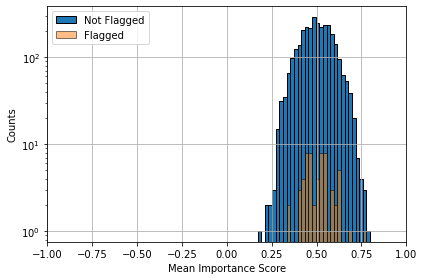

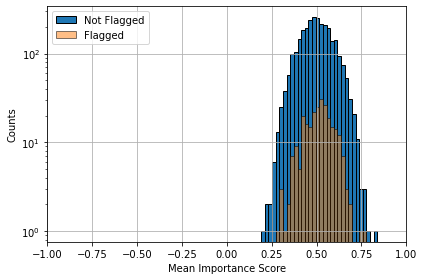

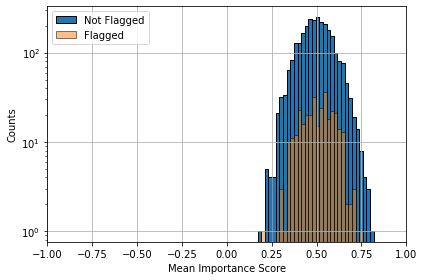

In [20]:
branch_explanations_trials = np.load(rand_analysis_root_dir / f'random_scores_trials_{n_trials}.npy')
branch_explanations_trials_avg = np.mean(branch_explanations_trials, axis=0)

bins = np.linspace(-1, 1, 100, endpoint=True)
flags = ['Flux Flag', 'Centroid Flag', 'Odd Even Flag', 'Secondary Flag', 'DV Flag']  # , 'No Flag']

for flag_i, flag in enumerate(flags):

    examples_pos = branch_explanations_trials_avg[:, flag_i][robo[:, flag_i] == 1]
    examples_neg = branch_explanations_trials_avg[:, flag_i][robo[:, flag_i] == 0]

    f, ax = plt.subplots()
    ax.hist(examples_neg, bins, edgecolor='k', zorder=0, label='Not Flagged')
    ax.hist(examples_pos, bins, edgecolor='k', zorder=1, label='Flagged', alpha=0.5)
    ax.set_xlabel('Mean Importance Score')
    ax.set_ylabel('Counts')
    ax.legend()
    ax.set_yscale('log')
    ax.grid()
    ax.set_xlim(bins[[0, -1]])
    f.tight_layout()
    f.savefig(rand_analysis_root_dir / f'hist_scores_flaggedvsnonflagged_flag_{flag}.pdf')

# Precision and recall threshold per flag

In [21]:
thr_arr = np.linspace(-1, 1, 100, endpoint=True)
precision_arr, recall_arr = np.nan * np.ones((n_trials, robo.shape[1], len(thr_arr)), dtype='float'), np.nan * np.ones((n_trials, robo.shape[1], len(thr_arr)), dtype='float')

for trial_i in range(n_trials):

    for thr_i, thr in enumerate(thr_arr):

        branch_explanations_thr = threshold(branch_explanations_trials[trial_i], thr)  # 1 - threshold(branch_explanations_trials, thr)

        # # add no_flag column; set to one when all other flags have non-positive explanation scores
        # noflag_explanation = np.zeros((len(branch_explanations_thr), 1), dtype='float')
        # noflag_explanation[(branch_explanations_thr == 0).all(axis=1)] = 1
        # branch_explanations_thr = np.concatenate([branch_explanations_thr, noflag_explanation], axis=1)

        for flag_i in range(robo.shape[1]):
            precision_arr[trial_i, flag_i, thr_i] = precision_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)
            recall_arr[trial_i, flag_i, thr_i] = recall_score(robo[:, flag_i], branch_explanations_thr[:, flag_i], zero_division=1)

precision_arr_mean = np.mean(precision_arr, axis=0)
recall_arr_mean = np.mean(recall_arr, axis=0)

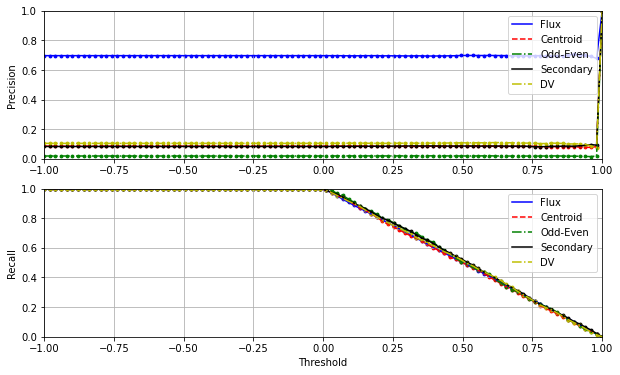

In [22]:
flag_plot_params = {
    'Flux': {'name': 'Flux', 'color': 'b', 'linestyle': '-'},
    'Centroid': {'name': 'Centroid', 'color': 'r', 'linestyle': '--'},
    'Odd-Even': {'name': 'Odd-Even', 'color': 'g', 'linestyle': '-.'},
    'Secondary': {'name': 'Secondary', 'color': 'k', 'linestyle': '-'},
    'DV': {'name': 'DV', 'color': 'y', 'linestyle': '-.'},
    # 'No Flag': {'name': 'No Flag', 'color': 'm', 'linestyle': '-.'},
}
f, ax = plt.subplots(2, 1, figsize=(10, 6))
for flag_i, flag in enumerate(flag_plot_params):
    ax[0].scatter(thr_arr, precision_arr_mean[flag_i, :], color=flag_plot_params[flag]['color'], s=8)
    ax[0].plot(thr_arr, precision_arr_mean[flag_i, :], label=flag_plot_params[flag]['name'], color=flag_plot_params[flag]['color'], linestyle=flag_plot_params[flag]['linestyle'])

    ax[1].scatter(thr_arr, recall_arr_mean[flag_i, :], color=flag_plot_params[flag]['color'], s=8)
    ax[1].plot(thr_arr, recall_arr_mean[flag_i, :], label=flag_plot_params[flag]['name'], color=flag_plot_params[flag]['color'], linestyle=flag_plot_params[flag]['linestyle'])

ax[0].set_ylabel('Precision')
ax[0].set_xlim(thr_arr[[0, -1]])
ax[0].set_ylim([0, 1])
ax[0].grid(True)
ax[0].legend()

ax[1].set_ylabel('Recall')
ax[1].set_xlim(thr_arr[[0, -1]])
ax[1].set_ylim([0, 1])
ax[1].grid(True)
ax[1].legend()
ax[1].set_xlabel('Threshold')

f.savefig(rand_analysis_root_dir / 'precision_recall_thr_per_flag.pdf')